In [1]:
import numpy as np
import os
import PIL
import PIL.Image
import pandas as pd

# Importing train data csv

In [2]:
#importing the train csv

import pandas as pd

plants=pd.read_csv('../plantbase/data/priority_plants_VF.csv').drop(columns='Unnamed: 0')

In [3]:
plants.head(10)

,id,family,genus,species,content
0,100005,Lamiaceae,Ajuga,Ajuga reptans L.,Flower
1,100038,Iridaceae,Iris,Iris lutescens Lam.,Flower
2,100144,Malvaceae,Malva,Malva sylvestris L.,Flower
3,10019,Orchidaceae,Ophrys,Ophrys apifera Huds.,Flower
4,100190,Geraniaceae,Geranium,Geranium sylvaticum L.,Flower
5,100201,Rosaceae,Crataegus,Crataegus germanica (L.) Kuntze,Flower
6,100229,Fabaceae,Trifolium,Trifolium alpinum L.,Flower
7,100255,Violaceae,Viola,Viola odorata L.,Flower
8,100273,Scrophulariaceae,Verbascum,Verbascum thapsus L.,Flower
9,100303,Rosaceae,Crataegus,Crataegus germanica (L.) Kuntze,Flower


# Understanding the train data balance & setting class_weights

In [4]:
#Class names based on genus
class_names={0: 'Ajuga',
 1: 'Allium',
 2: 'Campanula',
 3: 'Cirsium',
 4: 'Crataegus',
 5: 'Gentiana',
 6: 'Geranium',
 7: 'Iris',
 8: 'Malva',
 9: 'Narcissus',
 10: 'Ophrys',
 11: 'Rosa',
 12: 'Trifolium',
 13: 'Verbascum',
 14: 'Veronica',
 15: 'Viola'}

In [5]:
#flipping the dictionary so we can assign class number to every genus
class_numbers= {} 
for key, value in class_names.items(): 
   if value in class_numbers: 
       class_numbers[value].append(key) 
   else: 
       class_numbers[value]=key 
        
class_numbers

{'Ajuga': 0,
 'Allium': 1,
 'Campanula': 2,
 'Cirsium': 3,
 'Crataegus': 4,
 'Gentiana': 5,
 'Geranium': 6,
 'Iris': 7,
 'Malva': 8,
 'Narcissus': 9,
 'Ophrys': 10,
 'Rosa': 11,
 'Trifolium': 12,
 'Verbascum': 13,
 'Veronica': 14,
 'Viola': 15}

In [6]:
#Assigning the class number to each genus
plants['class']=plants['genus'].map(class_numbers)

plants.head()

,id,family,genus,species,content,class
0,100005,Lamiaceae,Ajuga,Ajuga reptans L.,Flower,0
1,100038,Iridaceae,Iris,Iris lutescens Lam.,Flower,7
2,100144,Malvaceae,Malva,Malva sylvestris L.,Flower,8
3,10019,Orchidaceae,Ophrys,Ophrys apifera Huds.,Flower,10
4,100190,Geraniaceae,Geranium,Geranium sylvaticum L.,Flower,6


In [7]:
#understanding how unbalanced our data set is
plants.groupby('class').count().sort_values(by='id',ascending=True)

,id,family,genus,species,content
class,,,,,
0,119,119,119,119,119
11,150,150,150,150,150
7,154,154,154,154,154
4,183,183,183,183,183
14,200,200,200,200,200
12,214,214,214,214,214
9,223,223,223,223,223
3,231,231,231,231,231
1,232,232,232,232,232


In [8]:
#setting class_weights based on the class 10. 
#Essentially we treating every instance of the classes as instances of class 10
# For example weight of 4 for class 0 means: 
    #treat every instance of class 0 as 4 instances of class 10

class_weight = {0:4. ,
                1:2., 
                2:1.5 ,
                3:2.,
                4:3.,
                5:2.,
                6:1.5,
                7:4.,
                8:2.,
                9:3.,
                10:1.,
                11:4.,
                12:3.,
                13:2.,
                14:3.,
                15:2.
               }

# Loading the images into train and validation sets

Load the images

In [9]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [10]:
#setting the directory for the train dataset
directory = r"../raw_data/train"

In [11]:
#augmenting the data using : horizontal flips, adapting the horiztontal width, shear range, zooming and rotating the images
train_datagen = ImageDataGenerator(
        rescale=1./255,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        rotation_range=90,
        validation_split = 0.2)

valid_datagen = ImageDataGenerator(
        rescale=1./255,
        validation_split = 0.2)

In [12]:
img_height, img_width = (256,256)

In [13]:
train_generator = train_datagen.flow_from_directory(
    directory,
    target_size=(img_height, img_width),
    batch_size=32,
    class_mode='binary',
    subset='training',
    seed = 123) # set as training data

validation_generator = valid_datagen.flow_from_directory(
    directory, # same directory as training data
    target_size=(img_height, img_width),
    batch_size=32,
    class_mode='binary',
    subset='validation',
    seed = 123) # set as validation data

Found 3460 images belonging to 16 classes.
Found 857 images belonging to 16 classes.


# Training baseline model

In [14]:
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

In [15]:
num_classes = 16

model = Sequential([
  #layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, input_shape=(img_height, img_width, 3),padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(64, activation='relu'),
  layers.Dense(num_classes)
])

In [16]:
import tensorflow.keras.losses

model.compile(optimizer='adam',
              loss=tensorflow.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [17]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 256, 256, 16)      448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 128, 128, 16)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 128, 128, 32)      4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 64, 64, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 64, 64, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 32, 32, 64)        0         
_________________________________________________________________
flatten (Flatten)            (None, 65536)             0

In [25]:
epochs=1
history = model.fit(
    train_generator,
    steps_per_epoch = train_generator.samples // 32,
    validation_data = validation_generator, 
    validation_steps = validation_generator.samples // 32,
    class_weight=class_weight,
    epochs = epochs)

108/108 [==============================] - 124s 1s/step - loss: 5.7763 - accuracy: 0.0980 - val_loss: 2.5051 - val_accuracy: 0.1635


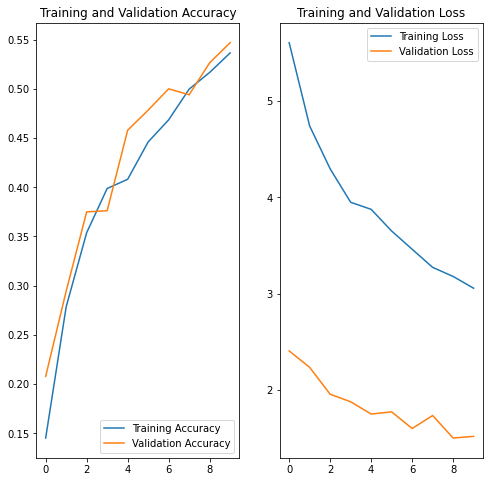

In [27]:
import matplotlib.pyplot as plt

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [29]:
model.save(r'../model/cnn_1_rm')

INFO:tensorflow:Assets written to: ../model/cnn_1_rm/assets


# Checking succession rate

#### Loading test csv

In [28]:
test_df = pd.read_csv("../plantbase/data/test_data.csv").drop(columns = "Unnamed: 0")

In [29]:
test_df = test_df[['id', 'genus']]
test_df.head()

,id,genus
0,100035,Verbascum
1,100058,Trifolium
2,100186,Veronica
3,100238,Campanula
4,1003,Geranium


In [30]:
columns = np.sort(test_df.genus.unique())
columns

array(['Ajuga', 'Allium', 'Campanula', 'Cirsium', 'Crataegus', 'Gentiana',
       'Geranium', 'Iris', 'Malva', 'Narcissus', 'Ophrys', 'Rosa',
       'Trifolium', 'Verbascum', 'Veronica', 'Viola'], dtype=object)

In [31]:
rename_columns = {}
col_index = 0
for n in columns:
    rename_columns[col_index] = n
    col_index += 1
    
rename_columns

{0: 'Ajuga',
 1: 'Allium',
 2: 'Campanula',
 3: 'Cirsium',
 4: 'Crataegus',
 5: 'Gentiana',
 6: 'Geranium',
 7: 'Iris',
 8: 'Malva',
 9: 'Narcissus',
 10: 'Ophrys',
 11: 'Rosa',
 12: 'Trifolium',
 13: 'Verbascum',
 14: 'Veronica',
 15: 'Viola'}

#### Loading test images using tensorflow load_img and img_to_array

In [32]:
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.preprocessing.image import img_to_array

In [33]:
X_list = []
y_list = []

for index, row in test_df.iterrows():
    img = load_img(rf"../raw_data/test/{row.id}.jpg", target_size=(256, 256))
    img = tensorflow.keras.preprocessing.image.img_to_array(img)
    #img = tensorflow.expand_dims(img, 0)
    X_list.append(img)
    y_list.append((row.genus, row.id))

In [34]:
y_true_df = pd.DataFrame(y_list, columns = ['true_genus', 'id'])
y_true_df.head()

,true_genus,id
0,Verbascum,100035
1,Trifolium,100058
2,Veronica,100186
3,Campanula,100238
4,Geranium,1003


In [35]:
X_test = np.stack(X_list, axis=0)

In [36]:
y_pred = model.predict(X_test)

In [37]:
y_pred.shape

(1341, 16)

In [38]:
y_pred_df = pd.DataFrame(y_pred)
y_pred_df = y_pred_df.rename(columns = rename_columns)
y_pred_df.head()

,Ajuga,Allium,Campanula,Cirsium,Crataegus,Gentiana,Geranium,Iris,Malva,Narcissus,Ophrys,Rosa,Trifolium,Verbascum,Veronica,Viola
0,-74.980453,-2568.295654,1171.377319,-794.796570,-3090.701416,4592.912109,281.661713,4569.379883,-1567.044800,3551.130371,1337.128784,-44.826385,-634.220764,4974.137695,-1799.487671,2505.231689
1,1938.828857,-2980.684570,-16.351919,-1607.685425,-2331.213135,3178.982666,573.730347,883.128235,-565.827881,-2174.989746,-1880.163208,-1221.078979,946.771118,511.898529,1817.633911,-85.706024
2,1656.068604,-1644.845947,1153.186157,-311.028564,-1537.616577,2287.315674,-536.583618,830.613037,-1117.316895,-606.424866,-940.623596,-1879.953247,-933.998352,886.870483,1519.078247,698.524841
3,539.016541,-574.553650,1067.678101,1802.304077,-2462.074463,1193.086792,359.455872,2327.891846,615.458374,-1024.085205,567.231323,-632.737854,37.785580,1213.698242,-883.079285,479.738953
4,113.601021,91.148277,1387.133301,-471.514771,-1909.707397,-18.869904,1566.364502,418.675690,1032.701782,-1208.287720,-95.583862,12.299157,-394.128601,36.178387,-375.552521,1102.260742


In [39]:
y_true = np.stack(y_list, axis = 0)

In [40]:
y_pred_df['pred_genus'] = y_pred_df.idxmax(axis = 1)
y_pred_df['pred_genus']

0       Verbascum
1        Gentiana
2        Gentiana
3            Iris
4        Geranium
5       Verbascum
6        Gentiana
7            Iris
8          Ophrys
9        Geranium
10       Geranium
11       Geranium
12           Iris
13          Malva
14      Verbascum
15      Verbascum
16      Campanula
17        Cirsium
18       Gentiana
19      Campanula
20          Malva
21        Cirsium
22       Gentiana
23       Geranium
24       Gentiana
25      Verbascum
26      Verbascum
27         Ophrys
28           Iris
29           Iris
          ...    
1311    Campanula
1312    Trifolium
1313     Gentiana
1314      Cirsium
1315      Cirsium
1316     Geranium
1317    Campanula
1318     Gentiana
1319      Cirsium
1320     Gentiana
1321    Campanula
1322    Campanula
1323    Verbascum
1324     Gentiana
1325        Malva
1326     Gentiana
1327        Malva
1328         Rosa
1329     Gentiana
1330     Gentiana
1331         Rosa
1332    Trifolium
1333    Verbascum
1334    Verbascum
1335      

In [41]:
prediction_review = (y_pred_df['pred_genus'] == y_true_df['true_genus'])

In [42]:
prediction_vec_df = y_pred_df[['pred_genus']].copy()
prediction_vec_df['true_genus'] = y_true_df['true_genus'].copy()
prediction_vec_df['result'] = (y_pred_df['pred_genus'] == y_true_df['true_genus'])

In [43]:
prediction_vec_df['false'] = prediction_vec_df['result'].apply(lambda x: 1 if x == False else 0)
prediction_vec_df['true'] = prediction_vec_df['result'].apply(lambda x: 1 if x == True else 0)
prediction_vec_df.head(2)

,pred_genus,true_genus,result,false,true
0,Verbascum,Verbascum,True,0,1
1,Gentiana,Trifolium,False,1,0


In [44]:
true_pos_neg = prediction_vec_df.groupby('true_genus').sum().drop(columns=['result'])
true_pos_neg['percent_true'] = true_pos_neg['true'] / (true_pos_neg['true'] + true_pos_neg['false'])

In [45]:
success_ratio = round(true_pos_neg[['percent_true']]*100).sort_values(by='percent_true', ascending=False)

In [46]:
success_ratio

,percent_true
true_genus,
Gentiana,86.0
Verbascum,78.0
Cirsium,76.0
Malva,53.0
Geranium,50.0
Narcissus,47.0
Rosa,44.0
Iris,40.0
Campanula,38.0


# VGG model

In [18]:
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.layers import Flatten, Dense

In [19]:
vgg_model = VGG16(input_shape=(256,256,3), weights=None, include_top=True, classes=16)

modelvgg = Sequential()
modelvgg.add(vgg_model)
modelvgg.add(Flatten())
modelvgg.add(Dense(16, activation='softmax'))    
modelvgg.compile(optimizer='adam',
          loss=tensorflow.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
          metrics=['accuracy'])

In [20]:
epochs=10
history = modelvgg.fit(
    train_generator,
    steps_per_epoch = train_generator.samples // 32,
    validation_data = validation_generator, 
    validation_steps = validation_generator.samples // 32,
    class_weight=class_weight,
    epochs = epochs)


Epoch 1/10
 73/108 [===================>..........] - ETA: 1:27:14 - loss: 5.9297 - accuracy: 0.0629

KeyboardInterrupt: 

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()